### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do the Matsubara and Pade analytical decompositions, as well as how to fit the latter with a finite set of approximate exponentials.  

### Drude-Lorentz spectral density
The Drude-Lorentz spectral density is:

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

The Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}



In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
from heom.pyheom import BosonicHEOMSolver

In [5]:
# Defining the system Hamiltonian
eps = .0     # Energy of the 2-level system.
Del = .2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [6]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

#tlist = np.linspace(0, 600, 600)

tlist = np.linspace(0, pi/Del, 600)
#Bath properties:
gamma = 1. # cut off frequency
lam = 2.5 # coupling strength
T = 1. # in units where Boltzmann factor is 1
beta = 1./T
#HEOM parameters
Nk = 1 # number of exponentials in approximation of the the spectral density
NC = 13 # cut off parameter for the bath

Text(0, 0.5, 'J')

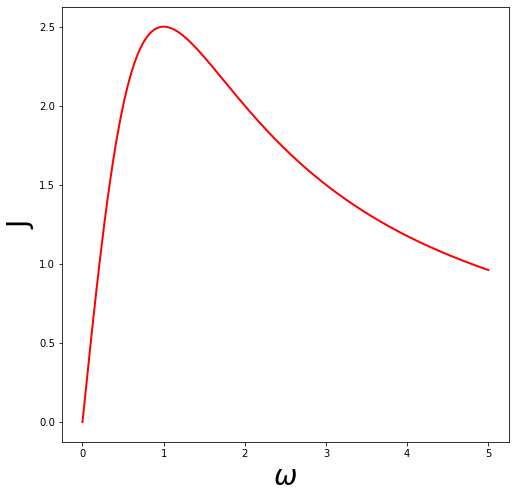

In [7]:
###############################################

# defines cks and vks for the Matsubara decomposition of the Drude Lorentz spectral density


def cot(x):
    return 1./np.tan(x)

wlist = np.linspace(0, 5, 1000)
pref = 1.

J = [w * 2 * lam * gamma / ((gamma**2 + w**2)) for w in wlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [8]:

def c(t):
    c_temp =[]
    c_temp.append(pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1,15000):
        vk = 2 * np.pi * k * T
        c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    return c_temp

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk+1)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk+1)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAR)
print(ckAI)

print(vkAR)
print(vkAI)




[(4.57621930428113+0j), (1.6329115640316914+0j)]
[(-2.5+0j)]
[(1+0j), (6.283185307179586+0j)]
[(1+0j)]


In [9]:
def Jw(w):
    Jt  = w * 2 * lam * gamma/ ((gamma**2 + w**2)) 
    return Jt



In [ ]:


def c(t):
    c_temp =[]
    c_temp.append(pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1,15000):
        vk = 2 * np.pi * k * T
        c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    return c_temp

# Reals parts
corrRana = [np.real(sum(c(t))) for t in tlist]
# Imaginary parts
corrIana = [np.imag(sum(c(t))) for t in tlist]


In [ ]:

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMMats = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)


In [ ]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   

resultMats = HEOMMats.run(rho0, tlist)


In [ ]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(resultMats.states, P11p)
P22exp = expect(resultMats.states, P22p)
P12exp = expect(resultMats.states, P12p)

In [ ]:
#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma
for k in range(1,Nk+1):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
L_bnd = -approx_factr*op

Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMMatsT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   

resultMatsT = HEOMMatsT.run(rho0, tlist)


In [ ]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expT = expect(resultMatsT.states, P11p)
P22expT = expect(resultMatsT.states, P22p)
P12expT = expect(resultMatsT.states, P12p)

In [ ]:

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11")

axes.plot(tlist, np.real(P11expT), 'b--', linewidth=2, label="P11")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

In [ ]:
#as a comparison, this is pade


lmax = 1



def deltafun(j,k):
    if j==k: 
        return 1.
    else:
        return 0.





Alpha =np.zeros((2*lmax,2*lmax))
for j in range(2*lmax):
    for k in range(2*lmax):
        #Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1)) #fermi
        Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #bose
        
eigvalsA=eigvalsh(Alpha)  

eps = []
for val in  eigvalsA[0:lmax]:
    #print(-2/val)
    eps.append(-2/val)
    

AlphaP =np.zeros((2*lmax-1,2*lmax-1))
for j in range(2*lmax-1):
    for k in range(2*lmax-1):
        #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #fermi
        
        AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+3)*(2*(k+1)+3)) #Bos: This is +3 because +1 (bose) + 2*(+1)(from bm+1)
        
eigvalsAP=eigvalsh(AlphaP)    


chi = []
for val in  eigvalsAP[0:lmax-1]:
    #print(-2/val)
    chi.append(-2/val)

    
#eta_list=[0.5*lmax*(2*(lmax + 1) - 1)*( 
#  np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
#    np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
#          for j in range(lmax)]
eta_list = []
prefactor = 0.5*lmax*(2*(lmax + 1) - 1)

for j in range(lmax):
    term = prefactor
    for k1 in range(lmax - 1):
        term *= (chi[k1]**2 - eps[j]**2)/(eps[k1]**2 - eps[j]**2 + deltafun(j,k1))        
    #term2 = 1
    for k2 in range(lmax-1,lmax):
        term /= (eps[k2]**2 - eps[j]**2 + deltafun(j,k2))
        #print(term2)
        
    eta_list.append(term)

#kappa = [0,1,1,1.56,14.44]
kappa = [0]+eta_list
print(kappa)
#epsilon = [0,1*pi,1*3*pi,1.06*5*pi,2.11*7*pi]
#print([0,1*pi,1*3*pi,1.06*5*pi,2.11*7*pi])
epsilon = [0]+eps



beta = 1/T

def f_approx(x):
    f = 0.5
    for l in range(1,lmax+1):
        f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
    return f

def f(x):
    kB=1.
    return 1/(1-exp(-x)) #this is n(w)+1  btw! (for bosons)


def C(tlist):
    eta_list = []
    gamma_list  =[]
    
    #l = 0
    #eta_0 = 0.5*lam*gamma*f(1.0j*beta*gamma)
    eta_0 =lam*gamma*(1.0/np.tan(gamma*beta/2.0) - 1.0j)
    gamma_0 = gamma
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append((kappa[l]/beta)*4*lam*gamma*(epsilon[l]/beta)/((epsilon[l]**2/beta**2)-gamma**2))
            gamma_list.append(epsilon[l]/beta)
            
     
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list


cppLP,etapLP,gampLP = C(tlist)


fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
ax1.plot(tlist,real(cppLP), color="b", linewidth=3, label= r"real pade 2")
#ax1.plot(tlist,imag(cppL), color="r", linewidth=3, label= r"imag alt")
ax1.plot(tlist,corrRana, "r--", linewidth=3, label= r"real mats 15000")
ax1.plot(tlist,real(cppL), "g--", linewidth=3, label= r"real mats 2")
#ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"imag ana")



ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()


fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
#ax1.plot(tlist,real(cppL), color="b", linewidth=3, label= r"real alt")
#ax1.plot(tlist,imag(cppL), color="r", linewidth=3, label= r"imag alt")
#ax1.plot(tlist,corrRana, "b--", linewidth=3, label= r"real ana")
#ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"imag ana")

ax1.plot(tlist,real(cppLP)-corrRana, color="b", linewidth=3, label= r"pade error")
ax1.plot(tlist,real(cppL)-corrRana, "r--", linewidth=3, label= r"mats error")

ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()


In [ ]:

ckAR = [real(eta) +0j for eta in etapLP]
ckAI = [imag(etapLP[0]) + 0j]

In [ ]:
vkAR = [gam +0j for gam in gampLP]
vkAI = [gampLP[0] + 0j]


In [ ]:
vkAR

In [ ]:


NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMPade = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)

resultPade = HEOMPade.run(rho0, tlist)

In [ ]:

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expP = expect(resultPade.states, P11p)
P22expP = expect(resultPade.states, P22p)
P12expP = expect(resultPade.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11 mats")
axes.plot(tlist, np.real(P11expT), 'r', linewidth=2, label="P11 mats++term")

axes.plot(tlist, np.real(P11expP), 'b--', linewidth=2, label="P11 pade")
#axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 mats")
#axes.plot(tlist, np.real(P12expP), 'r--', linewidth=2, label="P12 pade")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

### Do fitting of Matsubara expansion


In [ ]:
tlist2= linspace(0,6,10000)

lmaxmats = 15000

def c(t,anamax):

    c_temp = (pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        c_temp += ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
        
    
    return c_temp

# Reals parts
corrRana = [np.real(c(t,lmaxmats)) for t in tlist2]
# Imaginary parts
corrIana = [np.imag((pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))) for t in tlist2]


In [ ]:


from scipy.optimize import curve_fit
def wrapper_fit_func(x, N, *args):
    a, b = list(args[0][:N]), list(args[0][N:2*N])
    # print("debug")
    return fit_func(x, a, b, N)

# actual fitting function
def fit_func(x, a, b, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)
    return tot


def fitter(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        params_0 = [0]*(2*(i+1))
        upper_a = abs(max(ans, key = abs))*10
        #sets initial guess
        guess = []
        aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        bguess = [0]*(i+1)
        guess.extend(aguess)
        guess.extend(bguess)
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        b_lower.extend(alower)
        b_lower.extend(blower)
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0]*(i+1)
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        param_bounds = (b_lower, b_higher)
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist, ans, p0=guess, sigma=[0.01 for t in tlist2], bounds = param_bounds, maxfev = 1e8)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)

# function that evaluates values with fitted params at
# given inputs
def checker(tlist, vals):
    y = []
    for i in tlist:
        # print(i)
        y.append(wrapper_fit_func(i, int(len(vals)/2), vals))
    return y

k = 3
popt1 = fitter(corrRana, tlist2, k)
for i in range(k):
    y = checker(tlist2, popt1[i])
    plt.plot(tlist2, corrRana, tlist2, y)
    plt.show()

k1 = 1
popt2 = fitter(corrIana, tlist2, k1)
for i in range(k1):
    y = checker(tlist2, popt2[i])
    plt.plot(tlist2, corrIana, tlist2, y)
    plt.show()  


In [ ]:
ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR = [x+0j for x in ckAR1]
ckAI1 = list(popt2[k1-1])[:len(list(popt2[k1-1]))//2]
#minus?wtfiforgotagain
ckAI = [x+0j for x in ckAI1]
# vkAR, vkAI
vkAR1 = list(popt1[k-1])[len(list(popt1[k-1]))//2:]
vkAR = [-x+0j for x in vkAR1]
vkAI1 = list(popt2[k1-1])[len(list(popt2[k1-1]))//2:]
vkAI = [-x+0j for x in vkAI1]
# NC, NR, NI
# print(np.array(H).shape, np.array(Q).shape)
NC = 13
NR = len(ckAR)
NI = len(ckAI)

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


In [ ]:
#overwrite imaginary fit with analytical value jsut in case

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAI)
print(vkAI)

In [ ]:



NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMFit = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)


In [ ]:
#This can be very slow, maybe smaller Nc is sufficient
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 

start = time.time()
resultFit = HEOMFit.run(rho0, tlist)
end = time.time()
print(end - start)

In [ ]:



#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma
for k in range(1,lmaxmats):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
L_bnd = -approx_factr*op
print(approx_factr)
Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 

HEOMFitT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)

resultFitT = HEOMFitT.run(rho0, tlist)

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expFT = expect(resultFitT.states, P11p)
P22expFT = expect(resultFitT.states, P22p)
P12expFT = expect(resultFitT.states, P12p)


In [ ]:
# qsave(resultMats, 'resultMatsOD')
# qsave(resultMatsT, 'resultMatsTOD')
# qsave(resultPade, 'resultPadeOD')
# qsave(resultFit, 'resultFitOD')
#qsave(resultFitT, 'resultFitTOD')

In [ ]:
# resultFit = qload('resultFitOD')

In [ ]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()

In [ ]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()
rhoss = (states[0]*states[0].dag()*exp(-beta*energies[0]) + states[1]*states[1].dag()*exp(-beta*energies[1]))
rhoss = rhoss/rhoss.norm()

P11 = expect(rhoss,P11p)
P12 = expect(rhoss,P12p)

In [ ]:
DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)".format(gamma=gamma, beta = beta, lam = lam)

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)
outputBR  =  brmesolve(Hsys, rho0, tlist, a_ops=[[sigmaz(),DL]], options = optionsODE)


# Calculate expectation values in the bases
P11BR = expect(outputBR.states, P11p)
P22BR = expect(outputBR.states, P22p)
P12BR = expect(outputBR.states, P12p)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXGeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'

In [ ]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expF = expect(resultFit.states, P11p)
P22expF = expect(resultFit.states, P22p)
P12expF = expect(resultFit.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,5))

axes.plot(tlist, np.real(P11exp), 'r', linewidth=2, label="Matsubara K=1")
axes.plot(tlist, np.real(P11expT), 'g--', linewidth=2, label="Matsubara & terminator")
axes.plot(tlist, np.real(P11expP), 'y-.', linewidth=2, label="Pade K=1")
#axes.plot(tlist, np.real(P11BR), 'y-.', linewidth=2, label="Bloch Redfield")
axes.plot(tlist, np.real(P11expF), 'b:', linewidth=2, label="Correlation Fit")

axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)
axes.set_ylabel(r'$\rho_{11}$',fontsize=28)

axes.set_xlabel(r'$t\;\gamma$',fontsize=28)

axes.set_ylim(0.98405,1.0005)
axes.legend(loc=0)
# fig.savefig("fig2.pdf")

In [ ]:
from qutip.ipynbtools import version_table

version_table()